In [1]:
import sys
sys.path.append('../..')

import numpy as np

from olfactory_navigation.environment import Environment
from olfactory_navigation.agents import FSVI_Agent
from olfactory_navigation.agents.model_based_util.environment_converter import minimal_converter
from olfactory_navigation.test_setups import run_all_starts_test

In [2]:
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

In [3]:
indices = np.arange(101)
x,y = np.meshgrid(indices, indices)
pos = np.dstack((x, y))
rv = multivariate_normal([50, 50], 200)
probability_map = rv.pdf(pos)

# Normalize to have 1 at the center
probability_map /= np.max(probability_map)

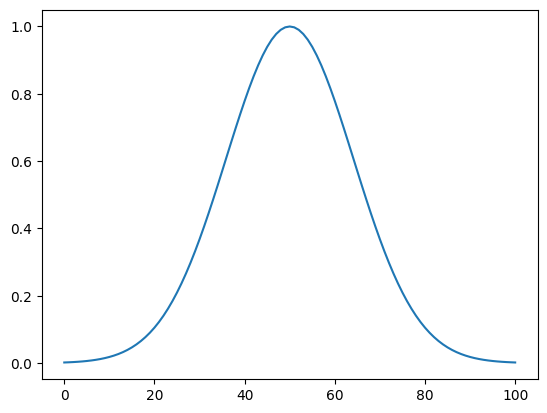

In [4]:
plt.plot(probability_map[50])

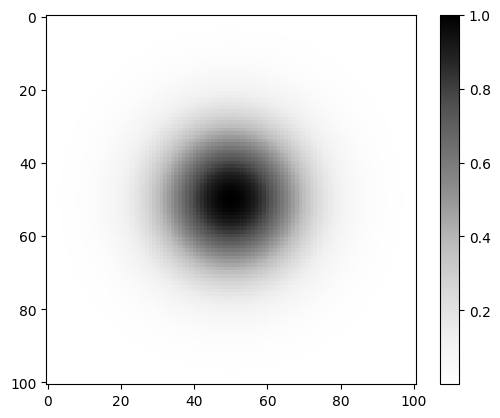

In [5]:
plt.imshow(probability_map, cmap='Greys')
plt.colorbar()

In [6]:
multiple_samples = (np.random.random((1000,101,101)) < probability_map).astype(float)

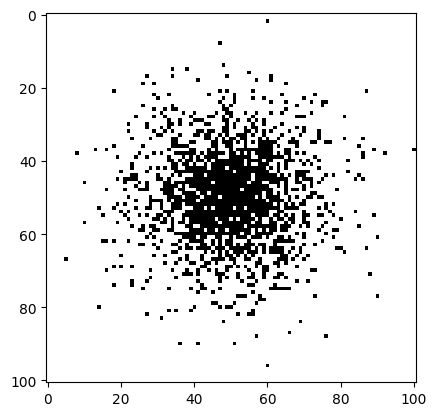

In [7]:
plt.imshow(multiple_samples[4], cmap='Greys')

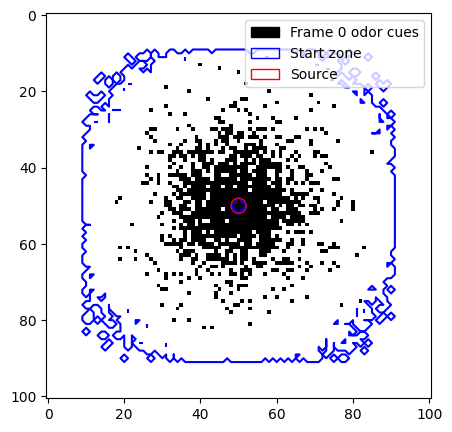

In [8]:
artificial_env  = Environment(data_file=multiple_samples,
                              data_source_position=[50, 50],
                              source_radius=2,
                              shape=[101,101],
                              margins=[10,10],
                              boundary_condition='stop',
                              start_zone='odor_present',
                              odor_present_threshold=3e-1)

artificial_env.plot()

In [9]:
partitions = [2]*2

In [10]:
ag = FSVI_Agent(environment=artificial_env,
                threshold=3e-1,
                environment_converter=minimal_converter,
                partitions=partitions)

[Warning] The whole dataset is being querried, it will be reshaped at this time. To avoid this, avoid querrying environment.data directly.


In [11]:
_ = ag.train(expansions=100, use_gpu=True)

[07/24/2024, 17:34:11] MDP_policy, not provided. Solving MDP with Value Iteration...
[07/24/2024, 17:34:11] Sending Model to GPU...
[07/24/2024, 17:34:12]     > Done in 1.164s


  0%|          | 0/1000 [00:00<?, ?it/s]

Summary of Value Iteration run
  - Model: 17-state, 4-action
  - Converged in 918 iterations and 2.4320 seconds
  - Took on average 0.0026s per iteration


Expansions:   0%|          | 0/100 [00:00<?, ?it/s]

Summary of Point Based Value Iteration run
  - Model: 17 state, 4 action, 3 observations
  - Converged or stopped after 100 expansion steps and 100 backup steps.
  - Resulting value function has 353 alpha vectors.
  - Converged in 9.3723s

  - Expand function took on average 0.0689s and yielded on average 171.86 beliefs per iteration. (0.0049s/it/belief)
  - Backup function took on average 0.0249s and yielded on average 3.49 alpha vectors per iteration. (0.0034s/it/alpha)
  - Pruning function took on average 0.0000s and yielded on average prunings of 0.00 alpha vectors per iteration.


[Warning] 'as_grid' parameter set to False but state count is >3 so it will be plotted as a grid


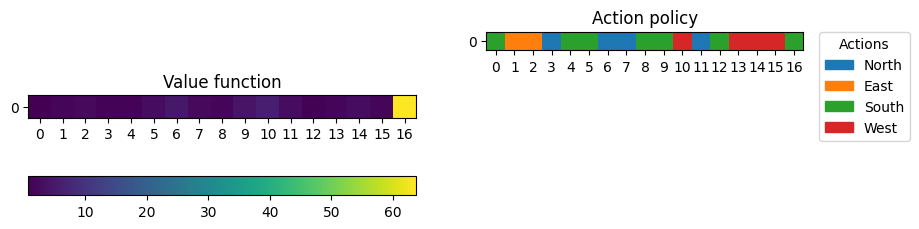

In [12]:
ag.value_function.plot()

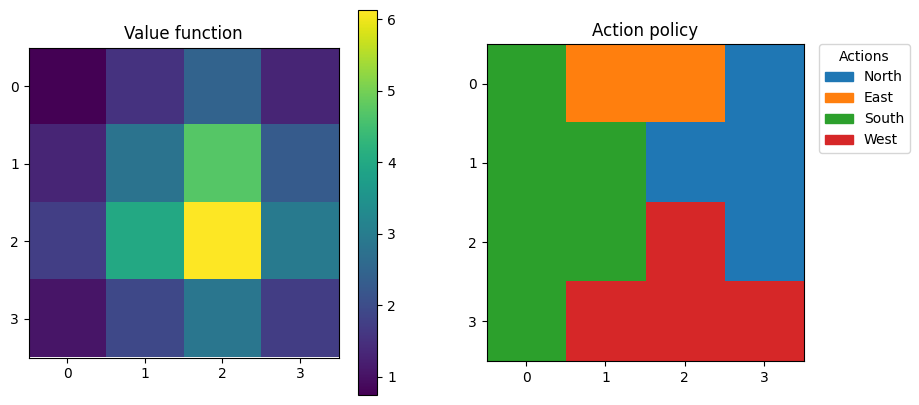

In [13]:
# CUSTOM PLOT
from matplotlib import colors, patches

COLOR_LIST = [{
    'name': item.replace('tab:',''),
    'id': item,
    'hex': value,
    'rgb': [int(value.lstrip('#')[i:i + (len(value)-1) // 3], 16) for i in range(0, (len(value)-1), (len(value)-1) // 3)]
    } for item, value in colors.TABLEAU_COLORS.items()] # type: ignore

COLOR_ARRAY = np.array([c['rgb'] for c in COLOR_LIST])

# VF
vf = ag.value_function
new_shape = [part+2 for part in partitions]

value_table = np.max(vf.alpha_vector_array, axis=0)[vf.model.state_grid[:,:-1]].reshape(new_shape)
best_action_table = np.array(vf.actions)[np.argmax(vf.alpha_vector_array, axis=0)][vf.model.state_grid[:,:-1]].reshape(new_shape)
best_action_colors = COLOR_ARRAY[best_action_table]

dimensions = new_shape

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(5*2, 5), width_ratios=(0.55,0.45))

# Ticks
x_ticks = np.arange(0, dimensions[1], (1 if dimensions[1] < 10 else int(dimensions[1] / 10)))
y_ticks = np.arange(0, dimensions[0], (1 if dimensions[0] < 5 else int(dimensions[0] / 5)))

ax1.set_title('Value function')
ax1_plot = ax1.imshow(value_table)

if dimensions[0] >= dimensions[1]: # If higher than wide 
    plt.colorbar(ax1_plot, ax=ax1)
else:
    plt.colorbar(ax1_plot, ax=ax1, location='bottom', orientation='horizontal')

ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)

ax2.set_title('Action policy')
ax2.imshow(best_action_colors)
p = [ patches.Patch(color=COLOR_LIST[int(i)]['id'], label=str(vf.model.action_labels[int(i)])) for i in vf.model.actions]
ax2.legend(handles=p, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='Actions')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)

In [14]:
import h5py
data_path = "C:\\Users\\arnau\\Desktop\\odor_source_15_15.h5"

loaded_data = h5py.File(data_path,'r')

In [15]:
data = np.array([loaded_data['odor_base'][timeslice] for timeslice in loaded_data['odor_base']])

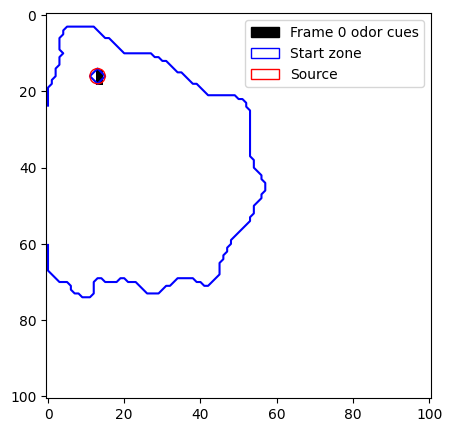

In [16]:
data_path = "C:\\Users\\arnau\\Desktop\\odor_source_15_15.h5"

source_position = (np.array([15,15]) / 0.8).astype(int)
tank_size = (np.array([90,110]) / 0.8).astype(int)

env = Environment(data_file=data,
                  data_source_position=[66, 66],
                  source_radius=2,
                  layers=False,
                  shape=[101,101],
                  margins=0,
                  boundary_condition='wrap_vertical',
                  start_zone='odor_present',
                  odor_present_threshold=3e-6)

env.plot()

In [17]:
hist = run_all_starts_test(ag, use_gpu=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 97.046s:
Simulations reached goal: 2167/5555 (3388 failures (reached horizon: 3388)) (39.01% success)
 - Average step count:                 658.827 +- 431.38 (Successfull only: 125.419 +- 102.58)
 - Extra steps:                        624.338 +- 431.22 (Successful only: 90.998 +- 99.95)
 - Average discounted rewards (ADR):   0.147 +- 0.23 (Successfull only: 0.376 +- 0.21)
 - Tmin/T:                             0.168 +- 0.22 (Successful only: 0.376 +- 0.22)


In [17]:
hist = run_all_starts_test(ag, environment=env, use_gpu=True)

Using the provided environment, not the agent environment.


  0%|          | 0/1000 [00:00<?, ?it/s]

Simulations done in 18.196s:
Simulations reached goal: 173/2936 (2763 failures (reached horizon: 2763)) (5.89% success)
 - Average step count:                 965.069 +- 160.00 (Successfull only: 407.185 +- 323.05)
 - Extra steps:                        926.765 +- 154.25 (Successful only: 396.890 +- 316.78)
 - Average discounted rewards (ADR):   0.015 +- 0.11 (Successfull only: 0.260 +- 0.38)
 - Tmin/T:                             0.047 +- 0.07 (Successful only: 0.154 +- 0.26)


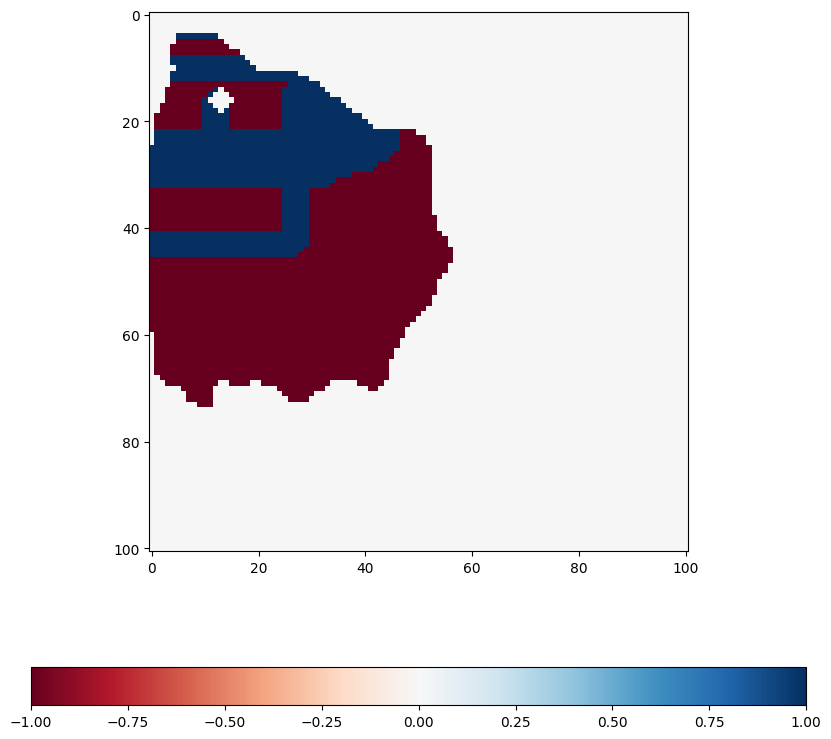

In [19]:
start_points_grid = np.zeros(env.shape)

failed_points = hist.start_points[hist.done_at_step == -1]
success_points = hist.start_points[hist.done_at_step != -1]

start_points_grid[failed_points[:,0], failed_points[:,1]] = -1
start_points_grid[success_points[:,0], success_points[:,1]] = 1

plt.figure(figsize=(10,10))
plt.imshow(start_points_grid, cmap='RdBu')
plt.colorbar(orientation='horizontal')

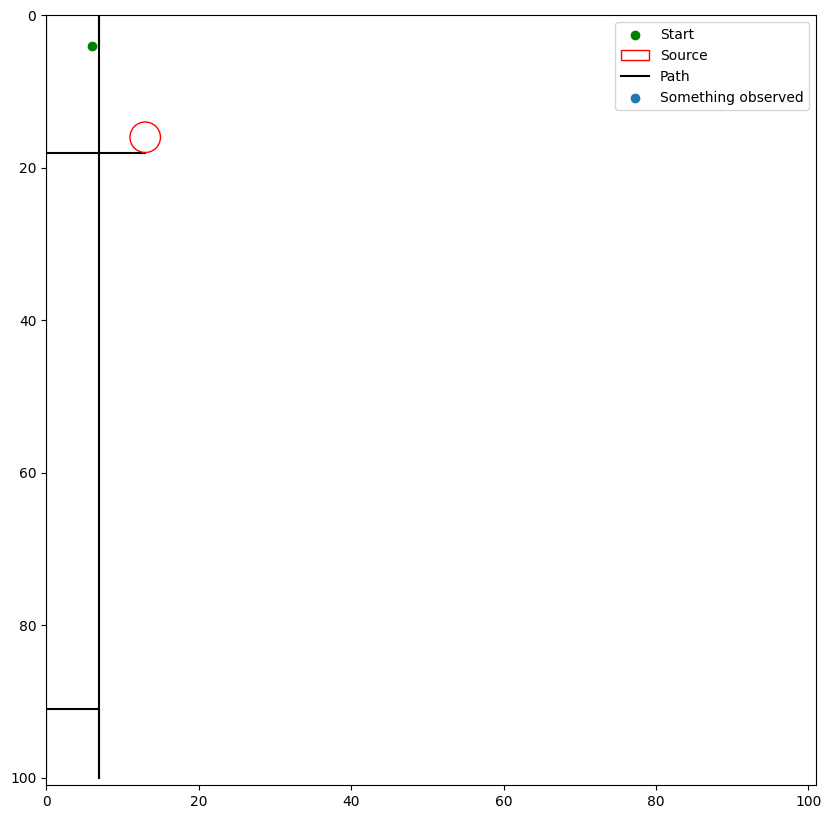

In [20]:
_, ax = plt.subplots(figsize=(10,10))
hist.plot(1, ax= ax)